### Tomato Maturity Detection and Quality Grading - `MOBILENETV3`

In this notebook we are going to train a model with the help of transfare learning on the `MOBILENETV3` achitecture that does  Tomato Maturity Detection and Quality Grading diagonisis based on `Tomato` images using the dataset that was obtained from kaggle at this url:

> https://www.kaggle.com/datasets/sujaykapadnis/tomato-maturity-detection-and-quality-grading


In the following code cell we are going to install the `helperfns` package that contains some helper functions that we are going to use in this notebook.

In [1]:
!pip install helperfns kaggle pigmenta -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.5/186.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.3/650.3 kB 27.6 MB/s eta 0:00:00


In the following code cell we are going to import all the packages that we are going to use for the rest of this notebook.

In [2]:
import torch
import random
import os
import time
import torchvision
import copy
import json
from pigmenta import PALETTES

import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import FileLink
from torch.nn import functional as F
from PIL import Image
from torchvision import datasets, transforms
from torch.utils import data
from PIL import Image
from sklearn.metrics import classification_report
from helperfns.tables import tabulate_data
from helperfns.visualization import plot_complicated_confusion_matrix, plot_simple_confusion_matrix
from helperfns.utils import hms_string

from helperfns import visualization
from torchvision import models
import matplotlib as mpl
import warnings

warnings.filterwarnings("ignore")
print("torch: ", torch.__version__)
print("numpy: ", np.__version__)
print("pandas: ", pd.__version__)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


torch:  2.6.0+cu124
numpy:  2.0.2
pandas:  2.2.2


### Seed

In the following code cell we are going to define the `SEED` for all random operation for reproducivity of results in this notebook.

In [3]:
SEED = 23

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

### Device

In the following code cell we are going to create a variable `device` that will hold the value of the device that is available so that we can have access to the `GPU` if available.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Dataset

The dataset that we will be using to train our model was found on Kaggle with the following URL:

> https://www.kaggle.com/datasets/sujaykapadnis/tomato-maturity-detection-and-quality-grading


In [5]:
with open('kaggle.json', 'r') as reader:
  keys = json.loads(reader.read())
  os.environ['KAGGLE_USERNAME'] = keys['username']
  os.environ['KAGGLE_KEY'] = keys['key']

!kaggle datasets download sujaykapadnis/tomato-maturity-detection-and-quality-grading --unzip

Dataset URL: https://www.kaggle.com/datasets/sujaykapadnis/tomato-maturity-detection-and-quality-grading
License(s): Attribution 4.0 International (CC BY 4.0)
100% 5.07G/5.08G [02:43<00:00, 43.3MB/s]
100% 5.08G/5.08G [02:43<00:00, 33.3MB/s]


Here we are going to have `2` dataset that we will use to train a model. A model should learn to detect tomato maturity and also be able to detemine the quality of the tomato. In the following code cell we are then going to create a dataset in a way that is easy for us to load the image dataset from path.

- We are going to make use of the original dataset for this task so we are going to move images with their respective classes in a folder namely: `maturity` and `quality`.

In [6]:
if not os.path.exists("datasets/maturity/mature"):
  os.makedirs("datasets/maturity/mature")

if not os.path.exists("datasets/maturity/inmature"):
  os.makedirs("datasets/maturity/inmature")

if not os.path.exists("datasets/quality/fresh"):
  os.makedirs("datasets/quality/fresh")

if not os.path.exists("datasets/quality/rotten"):
  os.makedirs("datasets/quality/rotten")

print("Done!")

Done!


In the next code cell we are then going to move images from `Normal` folder to the `dataset/train/normal` and `stone` to a folder called `dataset/train/stone`.

In [16]:
# tomato maturity

for file in os.listdir("Tomato Maturity Detection and Quality Grading Dataset/Tomato Maturity Detection Dataset/Tomato Maturity Detection Dataset/Original Dataset/Immature"):
  os.rename(f"Tomato Maturity Detection and Quality Grading Dataset/Tomato Maturity Detection Dataset/Tomato Maturity Detection Dataset/Original Dataset/Immature/{file}", f"datasets/maturity/inmature/{file}")

for file in os.listdir("Tomato Maturity Detection and Quality Grading Dataset/Tomato Maturity Detection Dataset/Tomato Maturity Detection Dataset/Original Dataset/Mature"):
  os.rename(f"Tomato Maturity Detection and Quality Grading Dataset/Tomato Maturity Detection Dataset/Tomato Maturity Detection Dataset/Original Dataset/Mature/{file}", f"datasets/maturity/mature/{file}")


# tomato quality

for file in os.listdir("Tomato Maturity Detection and Quality Grading Dataset/Tomato Quality Grading Dataset/Tomato Quality Grading Dataset/Original Dataset/Fresh"):
  os.rename(f"Tomato Maturity Detection and Quality Grading Dataset/Tomato Quality Grading Dataset/Tomato Quality Grading Dataset/Original Dataset/Fresh/{file}", f"datasets/quality/fresh/{file}")

for file in os.listdir("Tomato Maturity Detection and Quality Grading Dataset/Tomato Quality Grading Dataset/Tomato Quality Grading Dataset/Original Dataset/Rotten"):
  os.rename(f"Tomato Maturity Detection and Quality Grading Dataset/Tomato Quality Grading Dataset/Tomato Quality Grading Dataset/Original Dataset/Rotten/{file}", f"datasets/quality/rotten/{file}")
print("Done!")


Done!


### Channels Means and STDs

In the following code cell we are going to compute the means and standard deviations of all color channels in all images in the dataset so that we can use them to normalize the images during transformations.

> We are going to calculate the means and standard deviations for the tomato quality and maturity.

In [17]:
pretrained_size = 224

def get_means_stds(data_path):
  train_data = datasets.ImageFolder(
      root=data_path,
      transform= transforms.Compose([
          transforms.Resize(pretrained_size), # calculate means for the resized images according to the pretrained image size.
          transforms.ToTensor()
        ])
      )

  means = torch.zeros(3)
  stds = torch.zeros(3)

  for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

  means /= len(train_data)
  stds /= len(train_data)
  return means, stds


Means and Stds for the tomato quality.

In [18]:
quality_means, quality_stds = get_means_stds("datasets/quality")
print(f'Calculated means: {quality_means}')
print(f'Calculated stds: {quality_stds}')

Calculated means: tensor([0.7104, 0.6445, 0.6112])
Calculated stds: tensor([0.0977, 0.1952, 0.2105])


Means and the Stds for the maturity.

In [19]:
maturity_means, maturity_stds = get_means_stds("datasets/maturity")
print(f'Calculated means: {maturity_means}')
print(f'Calculated stds: {maturity_stds}')

Calculated means: tensor([0.4666, 0.4713, 0.3025])
Calculated stds: tensor([0.2010, 0.1837, 0.1917])


Since we will be using the `MOBILENETV3` for transfare learning we are going to use the pretrained size that this model expect which is `224`. For the means and standard deviation we are going to use the ones that we computed in the previous code cell for image normalization.

In [20]:
def get_image_transformations(means, stds):
  return {
    "train": transforms.Compose([
            transforms.Resize(pretrained_size),
            transforms.RandomRotation(5),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomCrop(pretrained_size, padding = 10),
            transforms.ToTensor(),
            transforms.Normalize(mean = means,
                                std = stds)
          ]),
    "valid": transforms.Compose([
          transforms.Resize(pretrained_size),
          transforms.ToTensor(),
          transforms.Normalize(mean = means,
                            std = stds)
        ]),
    "test": transforms.Compose([
          transforms.Resize(pretrained_size),
          transforms.ToTensor(),
          transforms.Normalize(mean = means,
                            std = stds)
    ])
  }

quality_image_transforms = get_image_transformations(quality_means, quality_stds)
maturity_image_transforms = get_image_transformations(maturity_means, maturity_stds)

In the following code cell we are then going to create a dataset 2 datasets for the tomato quality and maturity using the `ImageFolder` class that will map our classes to the respective images and handles a lot of work for us.

In [21]:
def get_datasets(data_path, image_transforms):
  ds = datasets.ImageFolder(data_path, transform = image_transforms['train'])
  return ds, ds.classes

quality_dataset, quality_classes = get_datasets("datasets/quality", quality_image_transforms)
maturity_dataset, maturity_classes = get_datasets("datasets/maturity", maturity_image_transforms)

We can check the class to index mapping of the dataset as follows..

In [22]:
quality_dataset.class_to_idx, maturity_dataset.class_to_idx

({'fresh': 0, 'rotten': 1}, {'inmature': 0, 'mature': 1})

### Validation and Test Splits

Next we are going to take `20%` the training and validation data from the training data.

In [23]:
VALID_RATIO = 0.2
TEST_RATIO = 0.2

def split_dataset(dataset):
  # Split into train + test
  n_test_examples = int(len(dataset) * TEST_RATIO)
  n_train_examples = len(dataset) - n_test_examples
  train_data, test_data = data.random_split(dataset,
                                            [n_train_examples, n_test_examples])

  # Split the training data into train + validation
  n_valid_examples = int(len(train_data) * VALID_RATIO)
  n_train_examples = len(train_data) - n_valid_examples
  train_data, valid_data = data.random_split(train_data,
                                            [n_train_examples, n_valid_examples])
  return train_data, valid_data, test_data

quality_train, quality_valid, quality_test = split_dataset(quality_dataset)
maturity_train, maturity_valid, maturity_test = split_dataset(maturity_dataset)

> Note that after spliting the train dataset into 2 subsets these 2 subsets will contain transforms of the train data. So we need to overide them. For that we are going to create a copy and overide the train transforms with respective transforms for each set.

In [24]:
def overide_transforms(valid_data, test_data, image_transforms):
    valid_data = copy.deepcopy(valid_data)
    test_data = copy.deepcopy(test_data)
    valid_data.dataset.transform = image_transforms['valid']
    test_data.dataset.transform = image_transforms['test']

overide_transforms(quality_valid, quality_test, quality_image_transforms)
overide_transforms(maturity_valid, maturity_test, maturity_image_transforms)

In the following code cell we are going to use the pie chat to visualize the examples that we have in each subset.

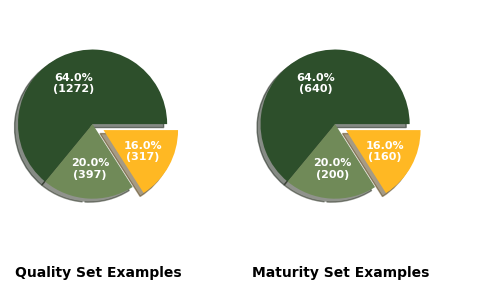

In [28]:
def fmt(x, total):
    return '{:.1f}%\n({:.0f})'.format(x, total * x / 100)

fig, axes = plt.subplots(1, 2, figsize=(5, 3))
# Quality pie chart
axes[0].pie(
    [len(quality_train), len(quality_test), len(quality_valid)],
    explode=[0, 0, 0.1],
    labels=['train', 'test', 'validation'],
    pctdistance=0.6, shadow=True,
    autopct=lambda x: fmt(x, len(quality_dataset)),
    textprops={'color': 'white', 'fontsize': 8, 'weight': 'bold'},
    radius=0.6, colors=PALETTES.vintage
)
axes[0].set_xlabel('Quality Set Examples', weight="bold", fontsize=10, labelpad=20)
axes[0].axis('equal')

# Maturity pie chart
axes[1].pie(
    [len(maturity_train), len(maturity_test), len(maturity_valid)],
    explode=[0, 0, 0.1],
    labels=['train', 'test', 'validation'],
    pctdistance=0.6, shadow=True,
    autopct=lambda x: fmt(x, len(maturity_dataset)),
    textprops={'color': 'white', 'fontsize': 8, 'weight': 'bold'},
    radius=0.6, colors=PALETTES.vintage
)
axes[1].set_xlabel('Maturity Set Examples', weight="bold", fontsize=10, labelpad=20)
axes[1].axis('equal')

plt.tight_layout()
plt.show()


Next we are going to create iterators and we are going to set the batch size to be `64`.

In [29]:
BATCH_SIZE = 64
maturity_train_iterator = data.DataLoader(
    maturity_train, shuffle=True, batch_size= BATCH_SIZE
)
maturity_valid_iterator = data.DataLoader(
    maturity_valid, batch_size= BATCH_SIZE
)
maturity_test_iterator = data.DataLoader(
    maturity_test, batch_size= BATCH_SIZE
)

quality_train_iterator = data.DataLoader(
    quality_train, shuffle=True, batch_size= BATCH_SIZE
)
quality_valid_iterator = data.DataLoader(
    quality_valid, batch_size= BATCH_SIZE
)
quality_test_iterator = data.DataLoader(
    quality_test, batch_size= BATCH_SIZE
)

### Visualizing Images

In this section of the notebook we are going to visualize the images that we have in our dataset with their respective labels.

In [30]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

Next we are going to define the `plot_images` function which is responsible for plotting images.

In [36]:
def plot_images(images, labels, class_names, redclass = 1, normalize = True):
  n_images = len(images)
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))
  fig = plt.figure(figsize = (10, 10))
  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    image = images[i]
    if normalize:
        image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(class_names[labels[i]], fontsize=10, color='r' if labels[i] == redclass else 'g')
    ax.axis('off')


Let's visualize the mature and imature example images in the dataset.

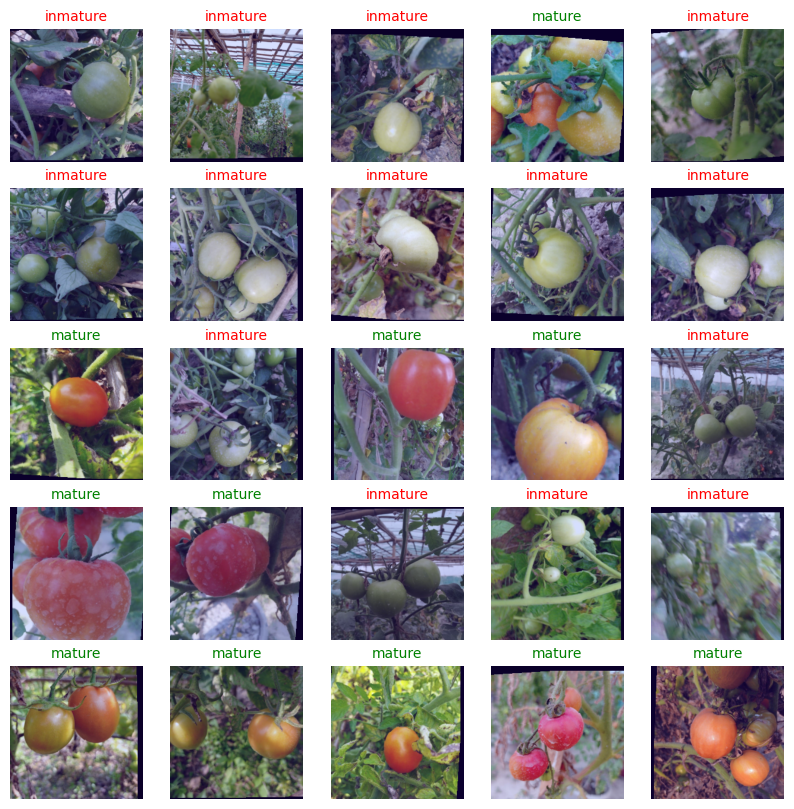

In [39]:
N_IMAGES = 25
images, labels = zip(*[(image, label) for image, label in
                           [maturity_train[i] for i in range(N_IMAGES)]])
plot_images(images, labels, maturity_classes, redclass=0)

Let's visualize tomato quality sample images in the dataset.

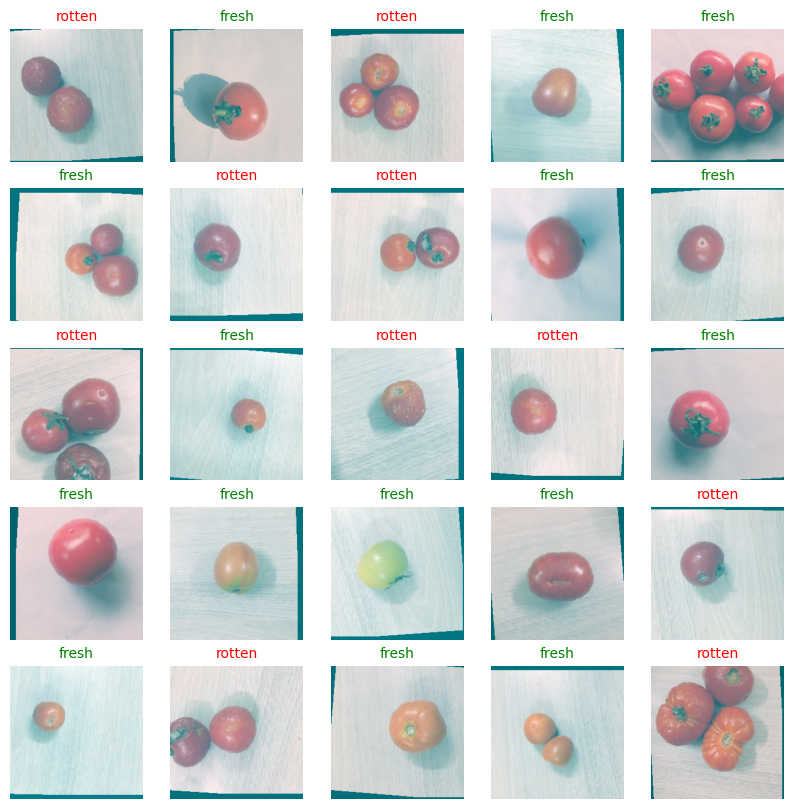

In [40]:
images, labels = zip(*[(image, label) for image, label in
                           [quality_train[i] for i in range(N_IMAGES)]])
plot_images(images, labels, quality_classes, redclass=1)

### Pretrained `MOBILENETV3`

In the following code cell we are going to load the `MOBILENETV3` model with it's weight.

> We are going to load 2 different models for quality and maturity.

In [42]:
quality_mobilenetv3 = models.mobilenet_v3_large(weights = True).to(device)
maturity_mobilenetv3 = models.mobilenet_v3_large(weights = True).to(device)

Next we are going to define the output dimension that matches the labels of our task.


> Note that we are not going to freeze the model in this case because we want to retrain the model and be able to update the weights to get the better results.

In [43]:
OUTPUT_DIM = 1
def freeze_model(model):
  for param in model.parameters():
    param.requires_grad = False

Next we are going to update the output layer of our `MOBILENETV3` to match the output size of `1` since we are doing a binary classification on tomato images.

In [44]:
quality_mobilenetv3.classifier[-1] = nn.Linear(quality_mobilenetv3.classifier[-1].in_features, OUTPUT_DIM).to(device)
maturity_mobilenetv3.classifier[-1] = nn.Linear(maturity_mobilenetv3.classifier[-1].in_features, OUTPUT_DIM).to(device)

Next we are going to create a function that will count the model parameters.

In [45]:
def count_params(model):
  total_params = sum([p.numel() for p in model.parameters()])
  trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
  return f'{total_params:,}', f'{trainable_params:,}', f'{total_params - trainable_params:,}'

Then we will visualize the model parameters using a table.

In [46]:
tabulate_data(
    ["NAME", "TOTAL PARAMETERS", "TRAINABLE PARAMETERS", "NON-TRAINABLE PARAMETERS"],
    [
      ['QUALITY_MOBILENETV3', *count_params(quality_mobilenetv3)],
      ['MATURITY_MOBILENETV3', *count_params(maturity_mobilenetv3)]
    ],
    "MODELS' PARAMETERS"
)


MODELS' PARAMETERS
+----------------------+------------------+----------------------+--------------------------+
| NAME                 | TOTAL PARAMETERS | TRAINABLE PARAMETERS | NON-TRAINABLE PARAMETERS |
+----------------------+------------------+----------------------+--------------------------+
| QUALITY_MOBILENETV3  |        4,203,313 |            4,203,313 |                        0 |
| MATURITY_MOBILENETV3 |        4,203,313 |            4,203,313 |                        0 |
+----------------------+------------------+----------------------+--------------------------+


### Criterion and Optmizer

Next we are going to define the optmizer to be `Adam` with default parameters and the loss function to be `BCELossWithLogitsLoss` since it is a binary classification task.

In [47]:
optimizers = {
    'quality': torch.optim.Adam(quality_mobilenetv3.parameters()),
    'maturity': torch.optim.Adam(maturity_mobilenetv3.parameters())
}
criterion = nn.BCEWithLogitsLoss().to(device)

Next we are going to define the `binary_accuracy` function that will calculate the accuracy between predicted labels and real labels.

In [48]:
def binary_accuracy(y_preds, y_true):
  rounded_preds = torch.round(torch.sigmoid(y_preds))
  correct = (rounded_preds == y_true).float()
  return correct.sum() / len(correct)

### Train and Evaluate Functions

In the following code cell we are going to define the `train` and `evaluate` fuctions.

In [49]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.train()
  for x, y in iterator:
    # features and labels to the device
    x = x.to(device)
    y = y.to(device).float() # they should be float
    # Zero the gradients
    optimizer.zero_grad()
    y_pred = model(x)

    # Calculate the loss and accuracy
    loss = criterion(y_pred, y.unsqueeze(1))
    acc = binary_accuracy(y_pred.squeeze(), y)
    # Backward propagate
    loss.backward()
    # Update the weights
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

def evaluate(model, iterator, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for x, y in iterator:
      x = x.to(device)
      y = y.to(device).float()  # they should be float
      y_pred = model(x)
      loss = criterion(y_pred, y.unsqueeze(1))
      acc = binary_accuracy(y_pred.squeeze(), y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

Next we are going to create a `History` wrapper class so that we can keep in track of the model's metrics during training.

In [50]:
class History:
  def __init__(self):
    self.train_losses = list()
    self.train_acc = list()
    self.epoch_train_time = list()
    self.val_losses = list()
    self.val_acc = list()

  def add(self, train_loss:float, train_acc:float, val_loss:float, val_acc:float, elt:float):
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_train_time.append(elt)

Next we are going to define the `train_model` function which is responsible for training the model and return model training history.

In [52]:
EPOCHS = 10
def train_model(model, model_name, train_iterator, optimizer, criterion, device, valid_iterator):
  best_valid_loss = float('inf')
  column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
  last_saved_epoch = 1

  history = History()
  training_start = time.time()
  for epoch in range(EPOCHS):
    start = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    save_status = "(not saving)"
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      save_status = "(saving)"
      last_saved_epoch = epoch + 1
      torch.save(model.state_dict(), model_name)

    end = time.time()
    history.add(train_loss, train_acc, valid_loss, valid_acc, end-start)


    data_rows = [
        ["Train", f'{train_loss:.3f}', f'{train_acc * 100:.2f}%', hms_string(end-start)],
        ["Validation", f'{valid_loss:.3f}', f'{valid_acc * 100:.2f}%', ""]
    ]

    title = f"{model_name.replace('.pt', '')}: EPOCH {epoch+1:02}/{EPOCHS}: {save_status}"
    tabulate_data(column_names, data_rows, title)

  training_end = time.time()
  return history, training_end - training_start, last_saved_epoch

Next we are going to run the train loop to train the tomato quality model.

In [53]:
quality_history, quality_training_end, quality_last_saved_epoch = train_model(
    quality_mobilenetv3, 'quality.pt', quality_train_iterator, optimizers['quality'], criterion, device,
    quality_valid_iterator
)

quality: EPOCH 01/10: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.208 |   92.17% | 0:00:27.86 |
| Validation | 1.015 |   85.55% |            |
+------------+-------+----------+------------+
quality: EPOCH 02/10: (not saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.099 |   96.13% | 0:00:27.18 |
| Validation | 1.966 |   80.81% |            |
+------------+-------+----------+------------+
quality: EPOCH 03/10: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.046 |   98.28% | 0:00:25.02 |
| Validation | 0.947 |   89.02% |            |
+------------+-------+----------+------------+
quality: EPOCH 04/10: (saving)
+------------+-------+----

In the next code cell we are then going to train a model that will access the tomato maturity.

In [54]:
maturity_history, maturity_training_end, maturity_last_saved_epoch = train_model(
    maturity_mobilenetv3, 'maturity.pt', maturity_train_iterator, optimizers['maturity'], criterion, device,
    maturity_valid_iterator
)

maturity: EPOCH 01/10: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.197 |   92.03% | 0:00:12.80 |
| Validation | 0.033 |   99.48% |            |
+------------+-------+----------+------------+
maturity: EPOCH 02/10: (not saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.043 |   98.75% | 0:00:14.67 |
| Validation | 0.419 |   92.19% |            |
+------------+-------+----------+------------+
maturity: EPOCH 03/10: (not saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.041 |   99.06% | 0:00:13.75 |
| Validation | 0.607 |   87.50% |            |
+------------+-------+----------+------------+
maturity: EPOCH 04/10: (not saving)
+------------+

### Model Training Time.

In the following code cell, using a table we are going to visualize the model's total training time and last saved epoch.

In [55]:
rows = [
    ['quality', f'{EPOCHS}', f'{hms_string(quality_training_end)}', f'{quality_last_saved_epoch}'],
    ['maturity', f'{EPOCHS}', f'{hms_string(maturity_training_end)}', f'{maturity_last_saved_epoch}']
]
tabulate_data(['MODEL','TOTAL EPOCHS', 'TOTAL TRAINING TIME', 'LAST SAVED EPOCH'], rows, "TOTAL TRAINING TIME")

TOTAL TRAINING TIME
+----------+--------------+---------------------+------------------+
| MODEL    | TOTAL EPOCHS | TOTAL TRAINING TIME | LAST SAVED EPOCH |
+----------+--------------+---------------------+------------------+
| quality  |           10 |          0:04:11.08 |                8 |
| maturity |           10 |          0:02:21.40 |               10 |
+----------+--------------+---------------------+------------------+


In the following code cell we are then going to visualize the model's training time per epoch/

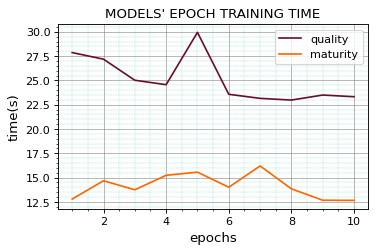

In [57]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, quality_history.epoch_train_time, label="quality", color=PALETTES.dark[6])
plt.plot(epochs, maturity_history.epoch_train_time, label="maturity", color=PALETTES.dark[55])
plt.title("MODELS' EPOCH TRAINING TIME", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.legend()
plt.show()

### Validation and Training Accuracies

In the following code cell we are going to visualize the model's training and validation accuracies per epoch using line graphs

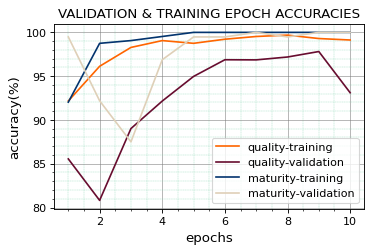

In [58]:
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, [i * 100 for i in quality_history.train_acc], label="quality-training", color=PALETTES.dark[55])
plt.plot(epochs, [i * 100 for i in quality_history.val_acc], label="quality-validation", color=PALETTES.dark[6])
plt.plot(epochs, [i * 100 for i in maturity_history.train_acc], label="maturity-training", color=PALETTES.dark[78])
plt.plot(epochs, [i * 100 for i in maturity_history.val_acc], label="maturity-validation", color=PALETTES.dark[8])
plt.title("VALIDATION & TRAINING EPOCH ACCURACIES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("accuracy(%)", fontsize=12)
plt.legend()

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

### Validation and Training Losses

In the following code cell we are going to visualize the model's training and validation losses per epoch using line graphs

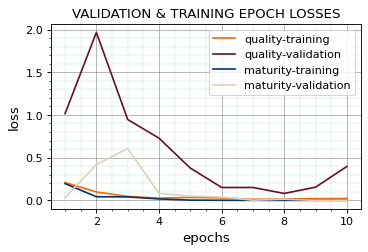

In [59]:
plt.figure(figsize=(5, 3), dpi=80)

plt.plot(epochs, quality_history.train_losses, label="quality-training", color=PALETTES.dark[55])
plt.plot(epochs, quality_history.val_losses, label="quality-validation", color=PALETTES.dark[6])
plt.plot(epochs, maturity_history.train_losses, label="maturity-training", color=PALETTES.dark[78])
plt.plot(epochs, maturity_history.val_losses, label="maturity-validation", color=PALETTES.dark[8])

plt.title("VALIDATION & TRAINING EPOCH LOSSES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("loss", fontsize=12)
plt.legend()

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

### Best Model Evaluation

In the following code cell we are going to create a function that will evaluate the best saved model during training interms of loss and accuracy based on the testing dataset.

In [61]:
def evaluate_best_model(model, model_name, test_iterator, criterion, device):
  model.load_state_dict(torch.load(model_name, weights_only=True))
  test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
  return f'{test_loss:.2f}', f'{test_acc * 100:.2f}'


tabulate_data(
    ["NAME", "LOSS", "ACCURACY (%)"],
    [
        ['quality', *evaluate_best_model(quality_mobilenetv3, 'quality.pt', quality_test_iterator, criterion, device)],
        ['maturity', *evaluate_best_model(maturity_mobilenetv3, 'maturity.pt', maturity_test_iterator, criterion, device)]
    ],
    "BEST MODEL'S LOSS AND ACCURACY"
)

BEST MODEL'S LOSS AND ACCURACY
+----------+------+--------------+
| NAME     | LOSS | ACCURACY (%) |
+----------+------+--------------+
| quality  | 0.05 |        98.21 |
| maturity | 0.03 |        99.61 |
+----------+------+--------------+


### Model Evaluation metrics
In this section we are going to evaluate the best model and visualize the matrics. We are going to use the following evaluation methods on this classification task.

1. confusion matrix
2. classification report.


First we need to get all the predictions from the train dataset.

In [82]:
#  I need to play around with this function
def get_predictions(model, iterator, device):
  model.eval()
  images = []
  labels = []
  probs = []
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y_pred = model(x)
      y_prob = F.sigmoid(y_pred).squeeze().detach()
      images.append(x.cpu())
      labels.append(y.cpu())
      probs.append(y_prob)
  images = torch.cat(images, dim = 0)
  labels = torch.cat(labels, dim = 0)
  probs = torch.cat(probs, dim = 0)
  return images, labels, probs

quality_test_images, quality_test_labels, quality_probs = get_predictions(quality_mobilenetv3, quality_test_iterator, device)
maturity_test_images, maturity_test_labels, maturity_probs = get_predictions(maturity_mobilenetv3, maturity_test_iterator, device)

Next we are going to convert our predictions from probabilities to real labels.

In [83]:
quality_preds = torch.round(quality_probs).cpu().numpy().astype(np.int32)
quality_test_labels = quality_test_labels.numpy()

maturity_preds = torch.round(maturity_probs).cpu().numpy().astype(np.int32)
maturity_test_labels = maturity_test_labels.numpy()

### Plotting Predictions

In this section we are going to plot the predictions.

We are going to create a function that will simplify things for us.

In [84]:
def get_values(images, preds, labels):
  images_labels = list(zip(images, preds, labels))
  random.shuffle(images_labels)
  y_true = []
  y_pred = []
  images = []
  for img, pred, label in images_labels:
    y_true.append(label)
    y_pred.append(pred)
    images.append(img)

  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  return images, y_true, y_pred

quality_images, quality_test_labels, quality_preds = get_values(quality_test_images, quality_preds, quality_test_labels)
maturity_images, maturity_test_labels, maturity_preds = get_values(maturity_test_images, maturity_preds, maturity_test_labels)

In [86]:
len(maturity_test_labels)

200

Next we are going to define the function that will plot the predictions for us.

In [87]:
def plot_predictions_images(images_and_classes,
                            labels_true, labels_pred,
                            class_names,
                            cols=5):
    rows = 3
    fig = plt.figure()
    fig.set_size_inches(cols * 2, rows * 2)
    for i, (image, label_true, label_pred) in enumerate(zip(images_and_classes, labels_true.astype("int32"), labels_pred)):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        image = normalize_image(image)
        plt.imshow(image.permute(1, 2, 0).cpu().numpy())
        plt.title(class_names[label_pred], color ='g' if label_true == label_pred else 'r', fontsize=10 )

Next we are going to plot tomato quality predictions.

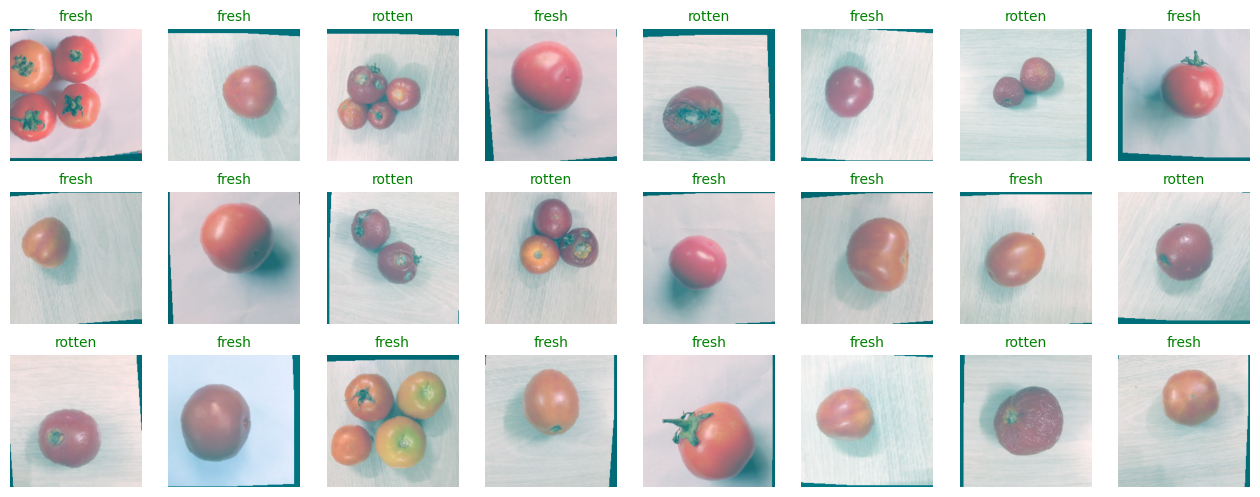

In [89]:
plot_predictions_images(quality_images[:24], quality_test_labels[:24], quality_preds[:24], quality_classes, cols=8)

Next we are going to plot tomato maturity predictions.

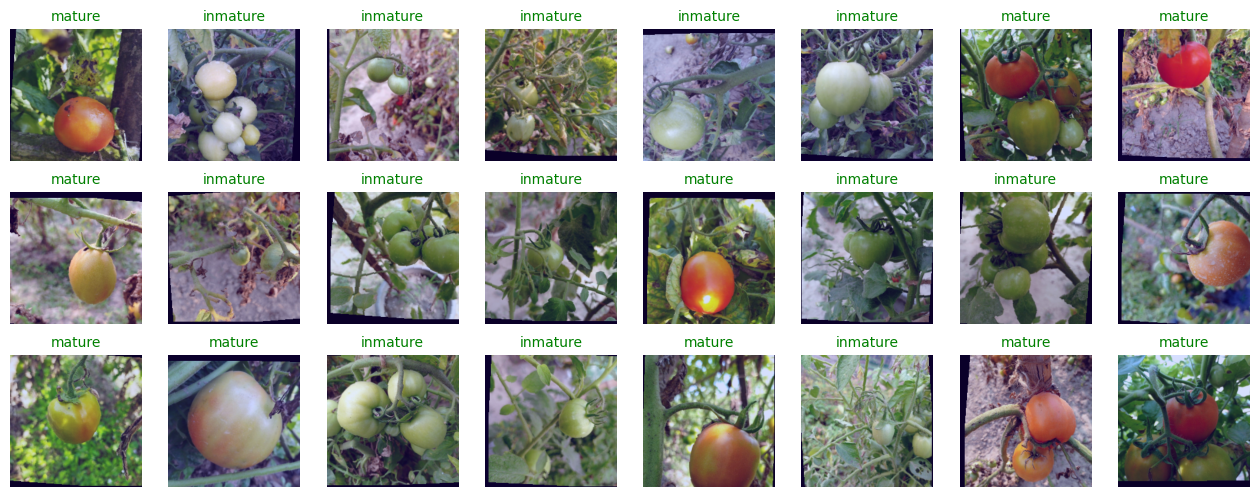

In [90]:
plot_predictions_images(maturity_images[:24], maturity_test_labels[:24], maturity_preds[:24], maturity_classes, cols=8)


### Confusion Matrix

In the following code cell we are going to visualize the confusion matrix of our model based on the test dataset.

1. Tomato Quality Model.

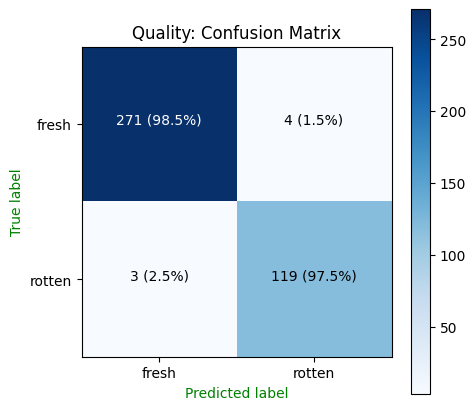

In [91]:
plot_complicated_confusion_matrix(quality_test_labels, quality_preds, quality_classes,
                                  fontsize=10, figsize=(5, 5), title="Quality: Confusion Matrix")

2. Tomato Maturity Model.

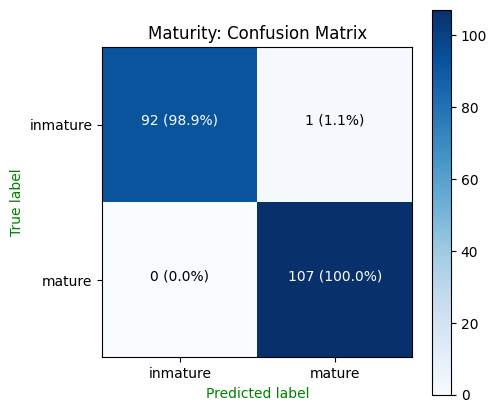

In [92]:
plot_complicated_confusion_matrix(maturity_test_labels, maturity_preds, maturity_classes,
                                  fontsize=10, figsize=(5, 5), title="Maturity: Confusion Matrix")

### Classification Report

In the following code cell we are going to print the classification report of our best model based on the test datast.

In the following code cell we are going to the plot the confusion matrix.

1. Tomato Maturity model.

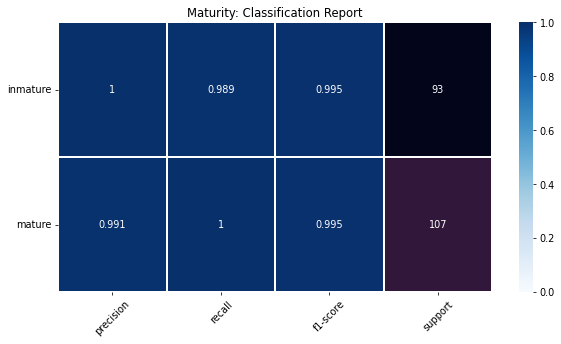

In [93]:
fig, ax = visualization.plot_classification_report(maturity_test_labels, maturity_preds,
                    title='Maturity: Classification Report',
                    figsize=(10, 5), dpi=70,
                    target_names = maturity_classes)

2. Tomato Quality Model.

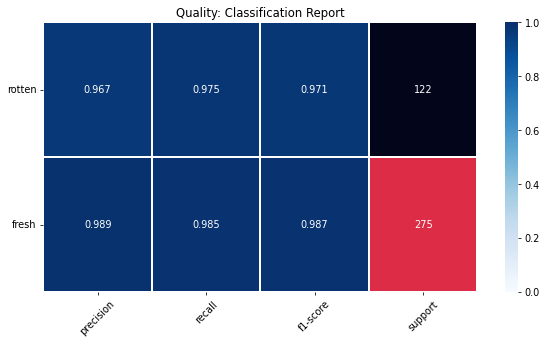

In [94]:
fig, ax = visualization.plot_classification_report(quality_test_labels, quality_preds,
                    title='Quality: Classification Report',
                    figsize=(10, 5), dpi=70,
                    target_names = quality_classes)

### Mis Predicted Images

In this section we are going to plot the mispredicted images of tomato if there are available.

In [95]:
def get_correct(test_labels, preds):
  return torch.eq(torch.from_numpy(test_labels), torch.from_numpy(preds))

quality_correct = get_correct(quality_test_labels, quality_preds)
maturity_correct = get_correct(maturity_test_labels, maturity_preds)

In [96]:
def get_probabilities(probs, preds):
  probabilities = torch.tensor(
      [float(probs[i] if probs[i] >= .5 else 1 - probs[i]) for i in preds]
  )
  return probabilities

quality_probabilities = get_probabilities(quality_probs, quality_preds)
maturity_probabilities = get_probabilities(maturity_probs, maturity_preds)

In [97]:
def get_incorrect_examples(images, labels, probabilities, corrects):
  incorrect_examples = []
  for image, label, prob, correct in zip(images, labels, probabilities, corrects):
    if not correct:
      incorrect_examples.append((image, label, prob))
  return incorrect_examples

quality_incorrect_examples = get_incorrect_examples(quality_test_images, quality_test_labels, quality_probabilities, quality_correct)
maturity_incorrect_examples = get_incorrect_examples(maturity_test_images, maturity_test_labels, maturity_probabilities, maturity_correct)


In [98]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))
  fig = plt.figure(figsize = (6, 4))
  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    image, true_label, probs = incorrect[i]
    image = image.permute(1, 2, 0)
    true_class = classes[true_label]
    incorrect_class = classes[0 if true_label == 1 else 1]
    if normalize:
      image = normalize_image(image)
    ax.imshow(image.cpu().numpy())
    ax.set_title(f'real: {true_class}\n' \
                  f'predicted: {incorrect_class}', fontsize=8)
    ax.axis('off')
  fig.subplots_adjust(hspace=0.4)

In the following code cell we are going to plot the most mispredicted `Tomato Quality` images by the model.

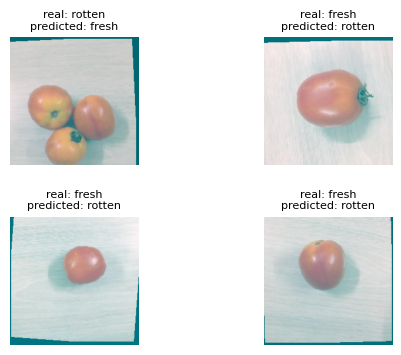

In [99]:

N_IMAGES = 8
try:
    plot_most_incorrect(quality_incorrect_examples, quality_classes, N_IMAGES)
except:
    print("No incorrectly Predicted Images")

Next we are going to do the same for the `Tomato Maturity` model.

No incorrectly Predicted Images


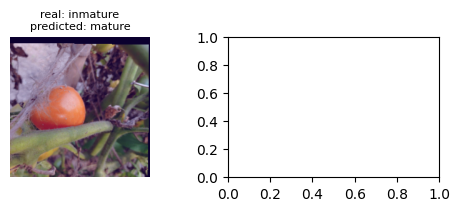

In [100]:
try:
    plot_most_incorrect(maturity_incorrect_examples, maturity_classes, N_IMAGES)
except:
    print("No incorrectly Predicted Images")

### Model Inference

In this section we are going to load one of the images from the file system and create a function that will make predictions using our models based on that image.

In [107]:
fresh_quality_image = os.path.join(
    'datasets', 'quality/fresh', os.listdir(os.path.join('datasets', 'quality/fresh'))[0]
)
rotten_quality_image = os.path.join(
    'datasets', 'quality/rotten', os.listdir(os.path.join('datasets', 'quality/rotten'))[0]
)
mature_maturity_image = os.path.join(
    'datasets', 'maturity/mature', os.listdir(os.path.join('datasets', 'maturity/mature'))[0]
)
inmature_maturity_image = os.path.join(
    'datasets', 'maturity/inmature', os.listdir(os.path.join('datasets', 'maturity/inmature'))[0]
)

Next we are going to define a function that will process the image by transforming it using the `test` transforms.

In [108]:
def preprocess_img(img:str, image_transforms):
  """
  takes in an image path and pre process it
  """
  img = image_transforms['test'](Image.open(img).convert('RGB'))
  return img

The following function will then make predictions using the model and give a prediction response.

In [112]:
def predict_quality_and_maturity(quality_model, maturity_model, image, device):
    image1 = preprocess_img(image, quality_image_transforms)
    image1 = torch.unsqueeze(image1, 0).to(device)

    image2 = preprocess_img(image, maturity_image_transforms)
    image2 = torch.unsqueeze(image2, 0).to(device)

    quality_model.eval()
    maturity_model.eval()
    with torch.no_grad():
        quality_pred = F.sigmoid(quality_model(image1).squeeze().cpu()).item()
        maturity_pred = F.sigmoid(maturity_model(image2).squeeze().cpu()).item()

        quality_predicted_label = 1 if quality_pred >= 0.5 else 0
        maturity_predicted_label = 1 if maturity_pred >= 0.5 else 0

        quality_confidence = quality_pred if quality_pred >= 0.5 else 1 - quality_pred
        maturity_confidence = maturity_pred if maturity_pred >= 0.5 else 1 - maturity_pred

        res ={
            'quality': {
                'label': quality_predicted_label,
                'class_label': quality_classes[quality_predicted_label],
                'probability': float(np.round(quality_confidence, 2))
            },
            'maturity': {
                'label': maturity_predicted_label,
                'class_label': maturity_classes[maturity_predicted_label],
                'probability': float(np.round(maturity_confidence, 2))
            }
        }
        return res

### Predictions

In [113]:
predict_quality_and_maturity(
    quality_mobilenetv3, maturity_mobilenetv3, fresh_quality_image, device
)

{'quality': {'label': 0, 'class_label': 'fresh', 'probability': 1.0},
 'maturity': {'label': 1, 'class_label': 'mature', 'probability': 1.0}}

In [114]:
predict_quality_and_maturity(
    quality_mobilenetv3, maturity_mobilenetv3, rotten_quality_image, device
)

{'quality': {'label': 1, 'class_label': 'rotten', 'probability': 1.0},
 'maturity': {'label': 1, 'class_label': 'mature', 'probability': 1.0}}

In [115]:
predict_quality_and_maturity(
    quality_mobilenetv3, maturity_mobilenetv3, mature_maturity_image, device
)

{'quality': {'label': 1, 'class_label': 'rotten', 'probability': 1.0},
 'maturity': {'label': 1, 'class_label': 'mature', 'probability': 1.0}}

In [116]:
predict_quality_and_maturity(
    quality_mobilenetv3, maturity_mobilenetv3, inmature_maturity_image, device
)

{'quality': {'label': 1, 'class_label': 'rotten', 'probability': 0.91},
 'maturity': {'label': 0, 'class_label': 'inmature', 'probability': 1.0}}